<a href="https://colab.research.google.com/github/Guivaluarte/DeepDream_tf/blob/main/DeepDream_Tensorflow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import tensorflow as tf

import numpy as np
import matplotlib as mpl

import time

import IPython.display as display
import PIL.Image


# Import Image

In [27]:
path = '/content/Img/Sem título.jpeg'

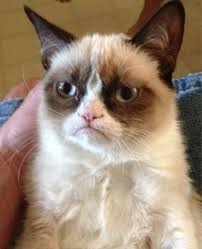

In [31]:
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def download(url, max_dim=None):
  img = PIL.Image.open(path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

original_img = download(path, max_dim=500)
show(original_img)


In [30]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [7]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs = base_model.input, outputs= layers)

# Calculate Loss


In [8]:
def calc_loss( img, model):
  img_batch = tf.expand_dims(img, axis =0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []

  for act in layer_activations:
      loss = tf.math.reduce_mean(act)
      losses.append(loss)

  return tf.reduce_sum(losses)


# Randomly shifting the image to create tiles

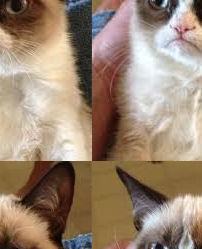

In [62]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

shift, img_rolled = random_roll(np.array(original_img), 512)

show(img_rolled)

# Gradient ascent Class

In [63]:
class DeepDreamer(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
          input_signature=(
                tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
                tf.TensorSpec(shape=[2], dtype=tf.int32),
                tf.TensorSpec(shape=[], dtype=tf.int32),
                )
          )

    def __call__(self, img, img_size, tile_size=512):
            print("Dreaming...")

            shift, img_rolled = random_roll(img, tile_size)
            gradients = tf.zeros_like(img_rolled)

            xs = tf.range(0, img_size[1], tile_size)[:-1]

            if not tf.cast(len(xs), bool):
                xs = tf.constant([0])

            ys = tf.range(0, img_size[0], tile_size)[:-1]

            if not tf.cast(len(ys), bool):
                ys = tf.constant([0])

            for x in xs:
                for y in ys:
                    with tf.GradientTape() as tape:
                        tape.watch(img_rolled)

                        img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
                        loss = calc_loss(img_tile, self.model)

                    gradients = gradients + tape.gradient(loss, img_rolled)

                gradients = tf.roll(gradients, shift=-shift, axis=[0,1])
                gradients /= tf.math.reduce_std(gradients) + 1e-8

            return gradients






In [64]:
deepdream = DeepDreamer(dream_model)

# Main Model Loop

In [70]:

def run_deep_dream(img, steps_per_octave=100, step_size=0.01, octaves=range(-2,3), octave_scale=1.2):
    base_shape = tf.shape(img)
    img = tf.keras.utils.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img,initial_shape)

    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]),tf.float32)*(octave_scale**octave)
        new_size = tf.cast(new_size, tf.int32)
        img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
        gradients = deepdream(img, new_size)
        img = img + gradients*step_size
        img = tf.clip_by_value(img,-1,1)

        if step % 10 == 0:
            display.clear_output(wait=True)
            show(deprocess(img))
            print ("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result









# Generating the image

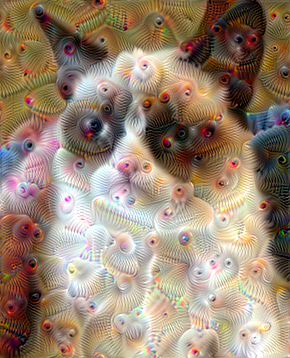

In [71]:
img = run_deep_dream(img=original_img, step_size=0.01)

base_shape = tf.shape(img)[:-1]

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

